# Curso NLP + Transformers

<img src="https://yaelmanuel.com/wp-content/uploads/2021/12/platzi-banner-logo-matematicas.png" width="500px">

---

# Análisis de Reseñas de Amazon 📦🔍

## 1) Carga y Exploración del Dataset 🤓

**Objetivo: Exploración del Dataset.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Descomprimir el archivo .rar

In [2]:
!unrar x "/content/reviews_dataframe_completo.rar"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/reviews_dataframe_completo.rar

Extracting  reviews_dataframe_completo.csv                                29% 59% 89%100%  OK 
All OK


Carga del dataset

In [3]:
csv_path = "/content/reviews_dataframe_completo.csv"
original_data = pd.read_csv(csv_path)

Visualizamos las primeras filas del dataset

In [4]:
original_data.head(3)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore


In [5]:
original_data.tail(3)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
209997,es_0760496,product_es_0731995,reviewer_es_0171091,5,Me ha encantado la diadema! Las flores son tal...,Excelente,es,toy
209998,es_0178380,product_es_0402051,reviewer_es_0686937,5,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,es,wireless
209999,es_0810087,product_es_0684221,reviewer_es_0613091,5,El artículo ha cumplido con las expectativas q...,Buena calidad,es,apparel


Distribución de las puntuaciones (stars)

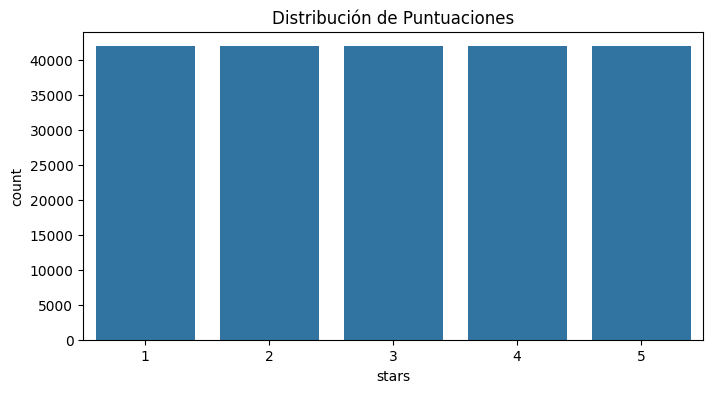

In [6]:
plt.figure(figsize=(8, 4))
sns.countplot(x='stars', data=original_data)
plt.title('Distribución de Puntuaciones')
plt.show()

Distribución de las categorías de productos

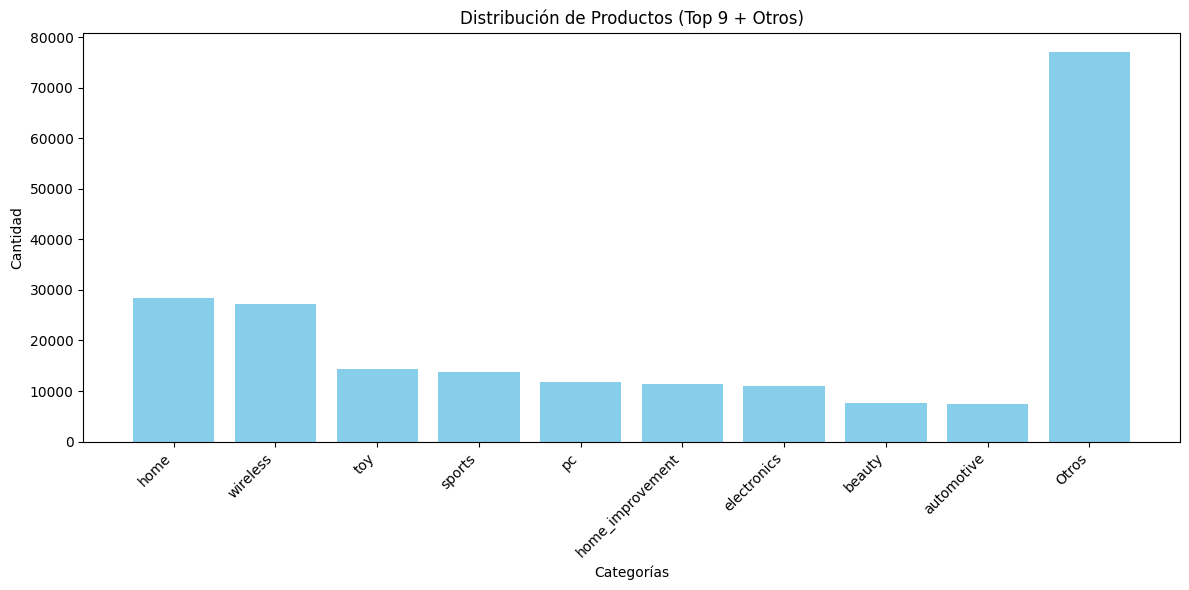

In [7]:
# Contar las categorías
product_category = original_data["product_category"].value_counts()

# Si hay más de 10 categorías, se toman las 9 principales y se agrupan las restantes en "Otros"
if len(product_category) > 10:
    top_categories = product_category.iloc[:9].copy()
    others = product_category.iloc[9:].sum()
    top_categories["Otros"] = others
else:
    top_categories = product_category

# Preparar etiquetas y valores
categories = top_categories.index
values = top_categories.values

plt.figure(figsize=(12,6))
plt.bar(categories, values, color='skyblue')
plt.xticks(rotation=45, ha="right")
plt.xlabel("Categorías")
plt.ylabel("Cantidad")
plt.title("Distribución de Productos (Top 9 + Otros)")
plt.tight_layout()
plt.show()


## 2) Preprocesamiento Inicial y Limpieza del Texto 👌

**Objetivo: Realizar un preprocesamiento con Regex (Expresiones Regulares).**

**Regex: Es una secuencia de caracteres que define un patrón de búsqueda**.

Se utiliza para ***describir, identificar y manipular*** cadenas de texto de manera eficiente.

Con expresiones regulares, puedes buscar coincidencias, extraer subcadenas, reemplazar partes de un texto o validar formatos de datos.

Nos vamos a quedar solo con la data de interés

In [8]:
filter_data = original_data[["review_body", "stars"]].copy()

In [9]:
filter_data.head(3)

,review_body,stars
0,Nada bueno se me fue ka pantalla en menos de 8...,1
1,"Horrible, nos tuvimos que comprar otro porque ...",1
2,Te obligan a comprar dos unidades y te llega s...,1


Evaluar valores nulos

In [10]:
filter_data.isnull().sum()

,0
review_body,0
stars,0


Limpiar el texto

In [11]:
import re
import string

In [12]:
def clean(text):
    # Convertir a minúsculas
    text = str(text).lower()

    # Eliminar textos entre corchetes (ej.: etiquetas)
    text = re.sub(r'\[.*?\]', '', text)

    # Eliminar URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Eliminar etiquetas HTML
    text = re.sub(r'<.*?>+', '', text)

    # Eliminar signos de puntuación
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    # Eliminar saltos de línea
    text = re.sub(r'\n', ' ', text)

    # Eliminar palabras que contienen números
    text = re.sub(r'\w*\d\w*', '', text)

    # Eliminar emojis y caracteres especiales (no ASCII)
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Eliminar espacios extras al inicio y final
    text = text.strip()

    return text

Aplicar la función de limpieza a la columna 'review_body'

In [13]:
filter_data["clean_review"] = filter_data["review_body"].apply(clean)

Ejemplo de reseña original vs. limpia:

In [14]:
filter_data[['review_body', 'clean_review']].head(3)

,review_body,clean_review
0,Nada bueno se me fue ka pantalla en menos de 8...,nada bueno se me fue ka pantalla en menos de ...
1,"Horrible, nos tuvimos que comprar otro porque ...",horrible nos tuvimos que comprar otro porque n...
2,Te obligan a comprar dos unidades y te llega s...,te obligan a comprar dos unidades y te llega s...


## 3) Tokenización y Segmentación de Reseñas 📊

**Objetivo: Realizar la tokenización y segmentación (división en palabras y oraciones) utilizando nltk y spaCy con modelos adaptados al español.**

**Tokenización:**
**Es el proceso de dividir el texto en unidades más pequeñas, llamadas tokens** (por ejemplo, palabras o signos de puntuación).

Esto es esencial para análisis posteriores como el conteo de palabras o la vectorización.

**Segmentación en Oraciones:**
Permite dividir el texto en oraciones, lo cual es útil para el análisis sintáctico y para preservar el contexto de cada enunciado.

### 📍 Con nltk

In [15]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

Descargar recursos de tokenización para español

In [16]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Seleccionar un ejemplo de reseña limpia

In [17]:
sample_text = filter_data["clean_review"].iloc[1]
print("Texto de ejemplo:", sample_text)

Texto de ejemplo: horrible nos tuvimos que comprar otro porque ni nosotros que sabemos ingls ni un informtico despus de una hora fue capaz de instalarlo


Tokenización y segmentación con nltk (para español)

In [18]:
tokens_nltk = word_tokenize(sample_text, language="spanish")
sentences_nltk = sent_tokenize(sample_text, language="spanish")

In [19]:
print("Tokens con nltk:", tokens_nltk)
print("Oraciones con nltk:", sentences_nltk)

Tokens con nltk: ['horrible', 'nos', 'tuvimos', 'que', 'comprar', 'otro', 'porque', 'ni', 'nosotros', 'que', 'sabemos', 'ingls', 'ni', 'un', 'informtico', 'despus', 'de', 'una', 'hora', 'fue', 'capaz', 'de', 'instalarlo']
Oraciones con nltk: ['horrible nos tuvimos que comprar otro porque ni nosotros que sabemos ingls ni un informtico despus de una hora fue capaz de instalarlo']


### 📍 Con spaCy

In [20]:
import spacy

In [21]:
!python3 -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 59.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [22]:
nlp_es = spacy.load('es_core_news_sm')
doc_es = nlp_es(sample_text)

In [23]:
tokens_spacy = [token.text for token in doc_es]
sentences_spacy = [sent.text for sent in doc_es.sents]

In [24]:
print("Tokens con spaCy:", tokens_spacy)
print("Oraciones con spaCy:", sentences_spacy)

Tokens con spaCy: ['horrible', 'nos', 'tuvimos', 'que', 'comprar', 'otro', 'porque', 'ni', 'nosotros', 'que', 'sabemos', 'ingls', 'ni', 'un', 'informtico', 'despus', 'de', 'una', 'hora', 'fue', 'capaz', 'de', 'instalarlo']
Oraciones con spaCy: ['horrible nos tuvimos que comprar otro porque ni nosotros que sabemos ingls ni un informtico despus de una hora fue capaz de instalarlo']


## 4) Stemming y Lematización para Reseñas 📚
**Objetivo: Refinar el preprocesamiento aplicando eliminación de stopwords, stemming y lematización para ver su efecto en las reseñas.**

**Stemming:** Consiste en recortar las palabras para reducirlas a su raíz (por ejemplo, "comprando" a "compr").

Sin embargo, este método puede producir resultados poco legibles y perder matices semánticos.
  
**Lematización:** Reduce las palabras a su forma canónica (o lema), preservando mejor el significado (por ejemplo, "comprando" se convierte en "comprar").

**Eliminación de Stopwords:**
Se utiliza para eliminar palabras muy comunes que no aportan información relevante (como “el”, “de”, “y”).

In [25]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

Descargar recursos necesarios en español

In [26]:
nltk.download('stopwords')
stopword_es = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
# Definir el stemmer para español
stemmer_es = SnowballStemmer("spanish")

# Seleccionar un ejemplo de reseña limpia
sample_text = filter_data["clean_review"].iloc[1]
print("Texto de ejemplo:", sample_text)

# Tokenización con nltk
tokens = word_tokenize(sample_text, language="spanish")

Texto de ejemplo: horrible nos tuvimos que comprar otro porque ni nosotros que sabemos ingls ni un informtico despus de una hora fue capaz de instalarlo


In [28]:
print("Tokens:", tokens)

Tokens: ['horrible', 'nos', 'tuvimos', 'que', 'comprar', 'otro', 'porque', 'ni', 'nosotros', 'que', 'sabemos', 'ingls', 'ni', 'un', 'informtico', 'despus', 'de', 'una', 'hora', 'fue', 'capaz', 'de', 'instalarlo']


In [29]:
# Eliminar stopwords
tokens_no_stop = [word for word in tokens if word not in stopword_es]
print("Tokens sin stopwords:", tokens_no_stop)

# Aplicar stemming
stemmed_tokens = [stemmer_es.stem(token) for token in tokens_no_stop]
print("Tokens después de stemming:", stemmed_tokens)

# Aplicar lematización usando spaCy
doc_es = nlp_es(sample_text)
lemmatized_tokens = [token.lemma_ for token in doc_es if token.text.lower() not in stopword_es]
print("Tokens después de lematización (sin stopwords):", lemmatized_tokens)

Tokens sin stopwords: ['horrible', 'comprar', 'sabemos', 'ingls', 'informtico', 'despus', 'hora', 'capaz', 'instalarlo']
Tokens después de stemming: ['horribl', 'compr', 'sab', 'ingls', 'informt', 'despus', 'hor', 'capaz', 'instal']
Tokens después de lematización (sin stopwords): ['horrible', 'comprar', 'saber', 'ingls', 'informtico', 'despus', 'hora', 'capaz', 'instalar él']


## 5) Visualización y Análisis Exploratorio del Texto 👀

**Objetivo: Visualizar la frecuencia de términos mediante nubes de palabras.**

In [32]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

### 📍 Reseñas Limpias

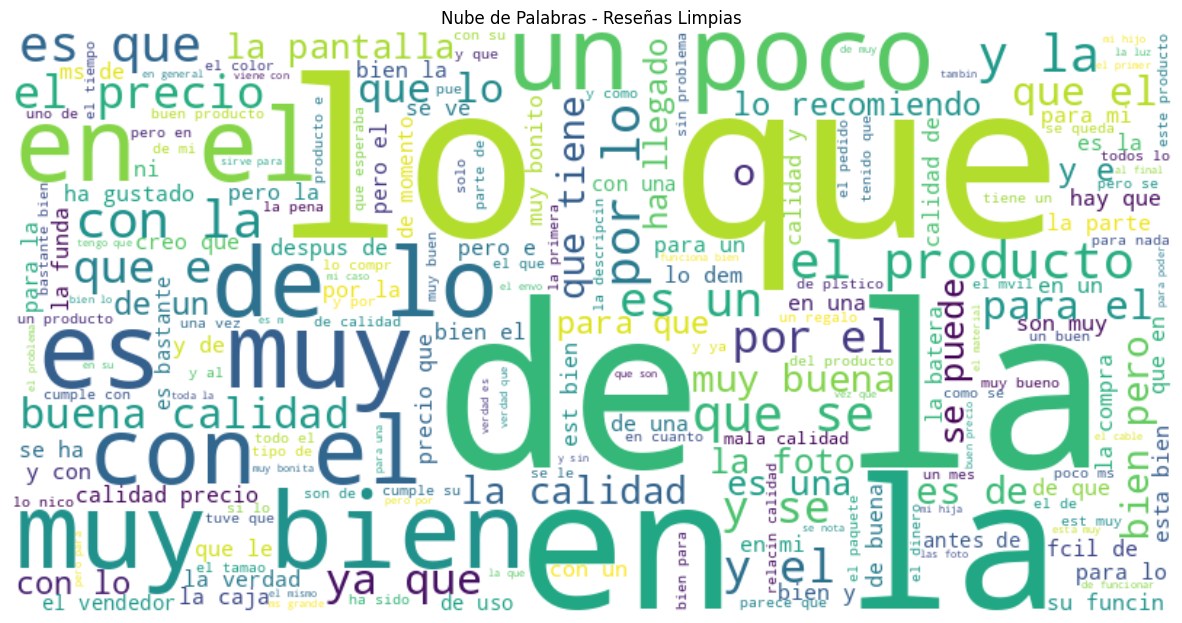

In [33]:
# Generar nube de palabras con las reseñas limpias
text = " ".join(review for review in filter_data["clean_review"])
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=800, height=400).generate(text)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras - Reseñas Limpias")
plt.show()

### 📍 Reseñas Limpias + Stopwords + Stemming

In [34]:
def clean_with_stopwords_and_stemming(text):
    # Eliminar stopwords
    text = " ".join([word for word in text.split() if word not in stopword_es])
    # Aplicar stemming
    text = " ".join([stemmer_es.stem(word) for word in text.split()])
    # Eliminar espacios extras al inicio y final
    return text.strip()

In [35]:
filter_data["clean_review_stemming"] = filter_data["clean_review"].apply(clean_with_stopwords_and_stemming)

# Mostrar ejemplos de texto limpio vrs texto limpio avanzado
filter_data[['clean_review', 'clean_review_stemming']].head(3)

,clean_review,clean_review_stemming
0,nada bueno se me fue ka pantalla en menos de ...,buen ka pantall men mes recib respuest fabric
1,horrible nos tuvimos que comprar otro porque n...,horribl compr sab ingls informt despus hor cap...
2,te obligan a comprar dos unidades y te llega s...,oblig compr dos unidad lleg sol form reclam au...


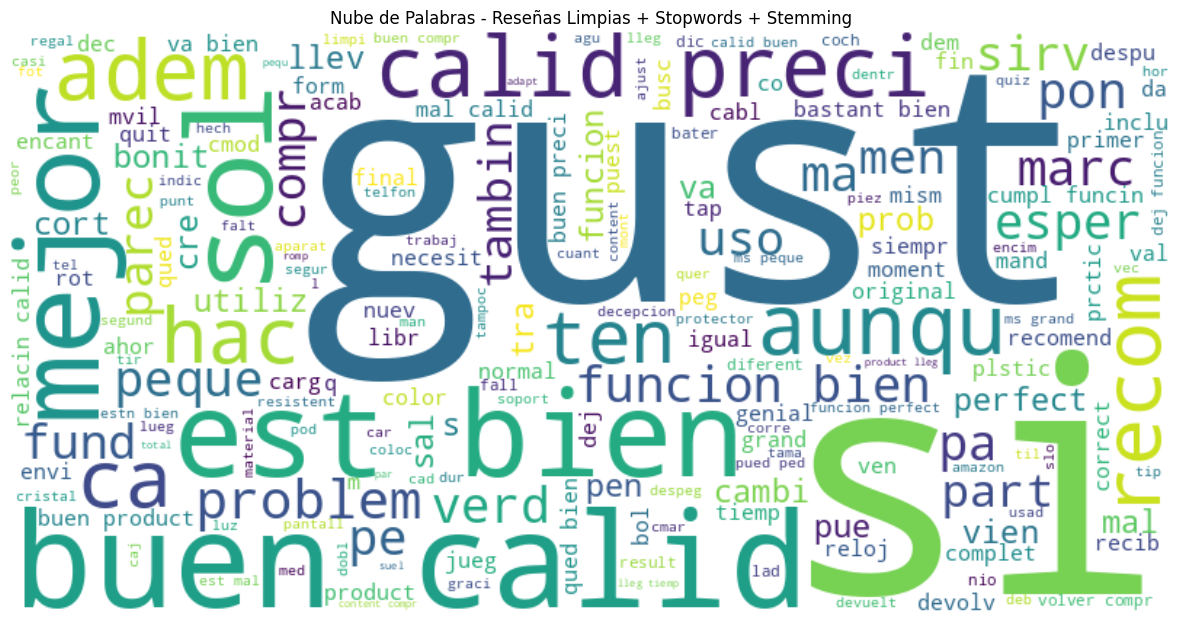

In [36]:
# Generar nube de palabras con las Reseñas Limpias + Stopwords + Stemming
text = " ".join(review for review in filter_data["clean_review_stemming"])
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=800, height=400).generate(text)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras - Reseñas Limpias + Stopwords + Stemming")
plt.show()

### 📍 Reseñas Limpias + Stopwords + Lemmatization

In [37]:
def clean_with_stopwords_and_lemmatization(text):
    # Procesar el texto usando spaCy
    doc = nlp_es(text)
    # Eliminar stopwords y aplicar lematización
    lemmatized = [token.lemma_ for token in doc if token.text.lower() not in stopword_es]
    # Unir los tokens lematizados y eliminar espacios extra
    return " ".join(lemmatized).strip()

In [38]:
filter_data["clean_review_lemmatization"] = filter_data["clean_review"].apply(clean_with_stopwords_and_lemmatization)

# Mostrar ejemplos de texto limpio vrs texto limpio avanzado
filter_data[['clean_review', 'clean_review_lemmatization']].head(3)

,clean_review,clean_review_lemmatization
0,nada bueno se me fue ka pantalla en menos de ...,bueno ko pantallar menos mes recibir respues...
1,horrible nos tuvimos que comprar otro porque n...,horrible comprar saber ingls informtico despus...
2,te obligan a comprar dos unidades y te llega s...,obligar comprar dos unidad llegar solo forma r...


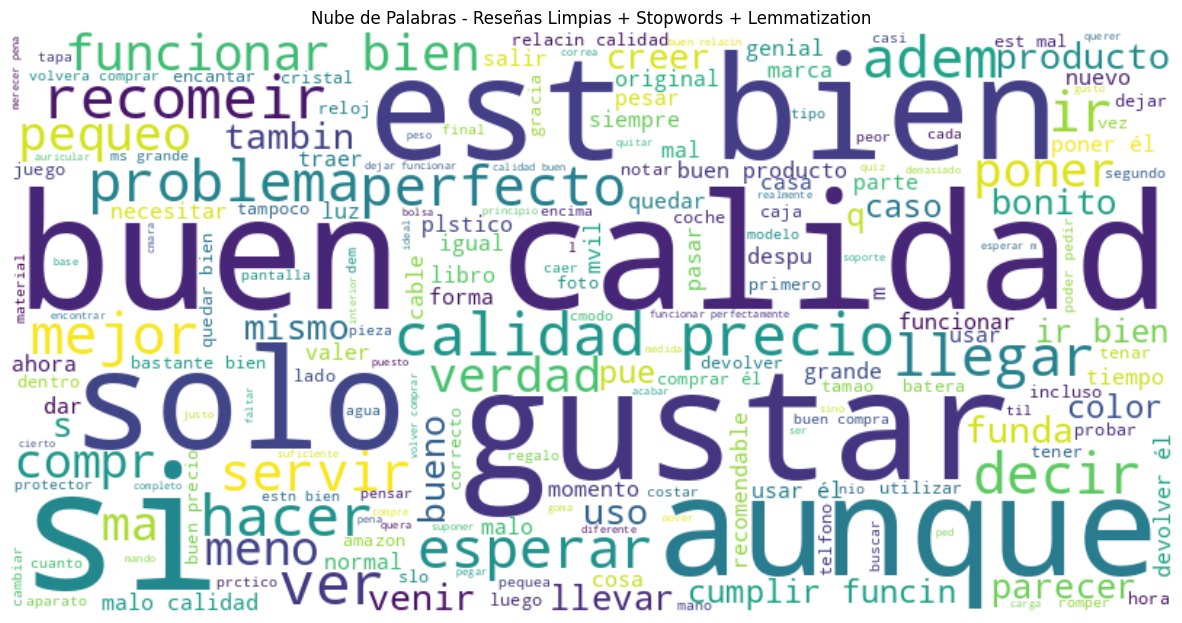

In [39]:
# Generar nube de palabras con las Reseñas Limpias + Stopwords + Lemmatization
text = " ".join(review for review in filter_data["clean_review_lemmatization"])
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=800, height=400).generate(text)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras - Reseñas Limpias + Stopwords + Lemmatization")
plt.show()

---
## 6) Guardar dataset limpio 💾

**Objetivo: Este dataset nos va a servir en etapas posteriores.**

In [40]:
filter_data[["clean_review_lemmatization", "stars"]].to_csv("reviews_clean_advanced.csv", index=False)